# Dim 3 point 

Compare different experiment trainings. 


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-19 21:06:37.766790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 21:06:37.780769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 21:06:37.784972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [2]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          #'mag_nabla_h_widened',
                                          #'filter_scale', 
                                          #'mag_nabla_u_widened',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : ['uphp_rotated',
                                        'vphp_rotated', 
                                        'mag_nabla_h_widened',
                                        'mag_nabla_u_widened',
                                        'filter_scale'],

                    'use_coeff_channels': False,

                    'all_time_range': slice(3300, 3600),
                    'train_time_range': slice(0, 1024),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],
                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/'
                    #'network_shape': [36, 36, 2],
                    #'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [3]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True)

In [4]:
DT.simulation_data['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 300, xh: 100, yh: 108, zl: 2, Xn: 3,
                                      Yn: 3, zi: 3)
    Coordinates:
      * Time                         (Time) object 2kB 0091-05-19 00:00:00 ... 00...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
      * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 467MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 467MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 467MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 467MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 467MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 467MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 52MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 52MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 52MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 52MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh) float64 26MB dask.array<chunksize=(12, 108, 100), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 26MB dask.array<chunksize=(12, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [5]:
exp_sets = { 'DG_only': { 'sel_sim' :'DG' }, 
             'P2L_only':{ 'sel_sim' :'P2L' }, 
             'DG_P2L':{'sel_sim' :['DG','P2L']}   
            }

In [6]:
for set_keys in exp_sets.keys(): 
    exp_sets[set_keys]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + set_keys


In [7]:
exp_sets

{'DG_only': {'sel_sim': 'DG',
  'save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/DG_only'},
 'P2L_only': {'sel_sim': 'P2L',
  'save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/P2L_only'},
 'DG_P2L': {'sel_sim': ['DG', 'P2L'],
  'save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/DG_P2L'}}

In [8]:
# Load in and get the models ready to evaluate
for set_keys in exp_sets.keys():
    print(exp_sets[set_keys]['save_dir'])
    exp_sets[set_keys]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                             input_channels=experiment_config['input_channels'],
                                             output_channels=experiment_config['output_channels'], 
                                             coeff_channels=experiment_config['coeff_channels'], 
                                             extra_channels=experiment_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= experiment_config['eval_time_range'], 
                                             num_inputs=experiment_config['num_inputs'], 
                                             shape=experiment_config['network_shape'], 
                                             ckpt_dir=exp_sets[set_keys]['save_dir'],
                                             use_coeff_channels=experiment_config['use_coeff_channels'])

    
    exp_sets[set_keys]['eval_sys'].read_ann_regression_model()
    exp_sets[set_keys]['eval_sys'].read_eval_data()
    exp_sets[set_keys]['eval_sys'].predict()
    exp_sets[set_keys]['eval_sys'].dimensionalize()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/DG_only
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/P2L_only
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/DG_P2L


In [19]:
# Compute some metrics for each model 
for set_keys in exp_sets.keys():
    print(set_keys)
    

 
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='layer_wise', dims=['Time','xh','yh'], use_default_subregions=True)
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='layer_wise', dims=['Time','xh','yh'], use_default_subregions=True)

    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

DG_only
P2L_only
DG_P2L


Text(0.5, 1.0, 'DG_P2L')

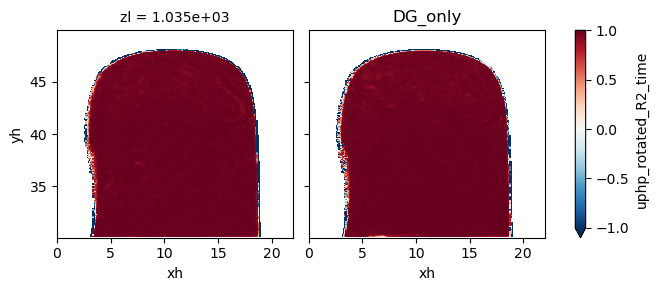

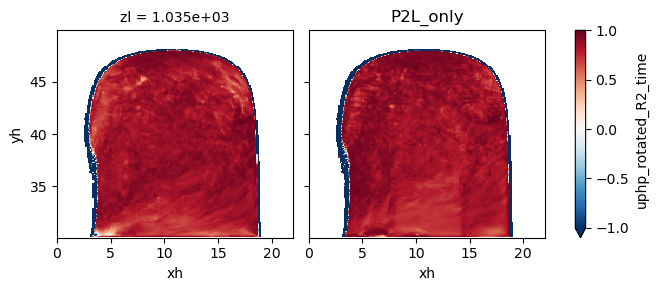

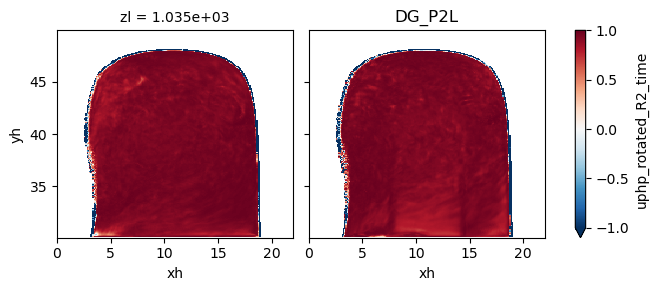

In [27]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

Text(0.5, 1.0, 'DG_P2L')

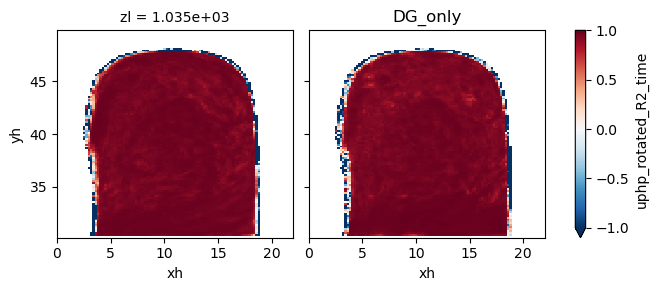

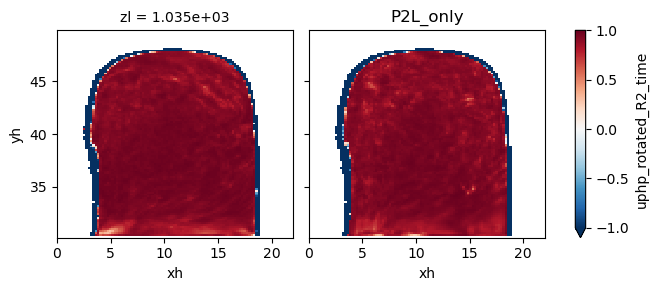

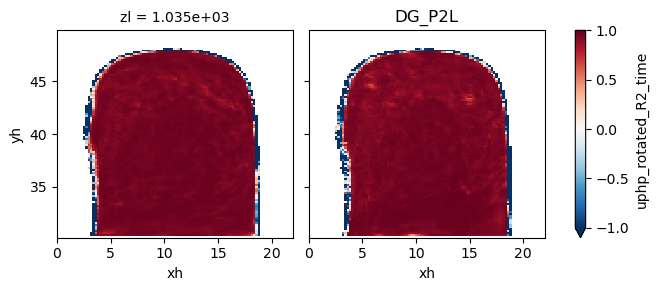

In [20]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

Text(0.5, 1.0, 'DG_P2L')

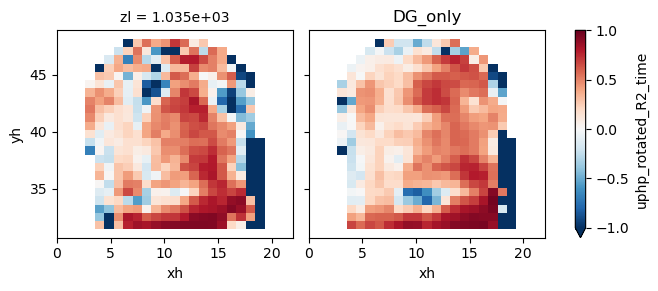

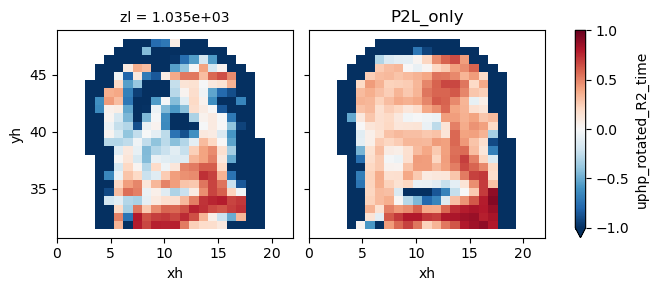

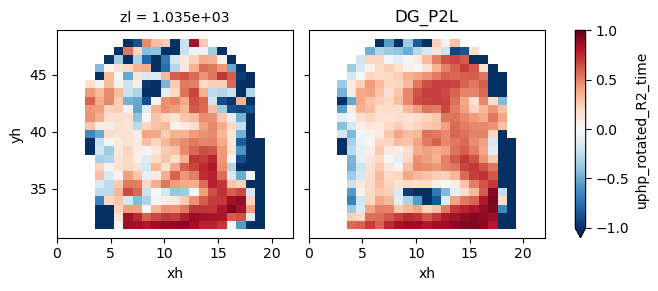

In [21]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['DG']['400'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['DG']['400'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['DG']['400'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

Text(0.5, 1.0, 'DG_P2L')

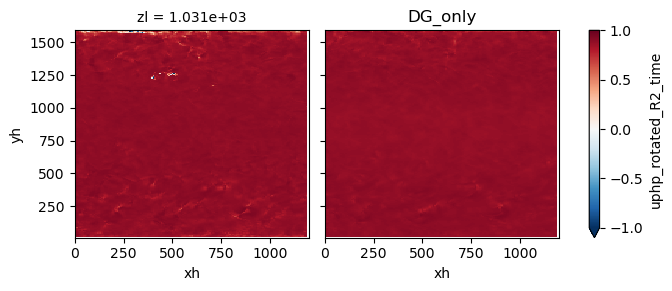

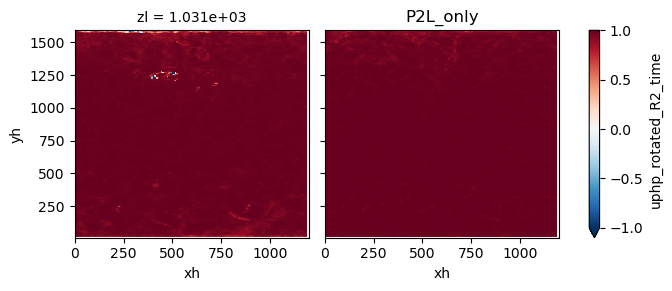

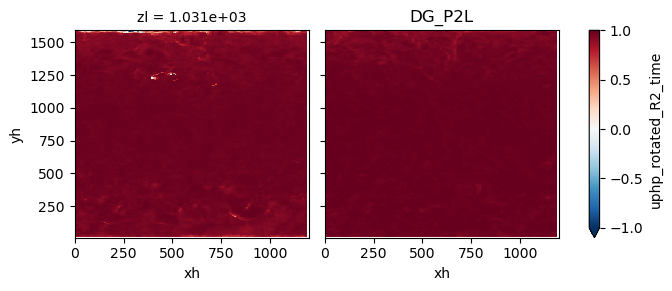

In [28]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['P2L']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

Text(0.5, 1.0, 'DG_P2L')

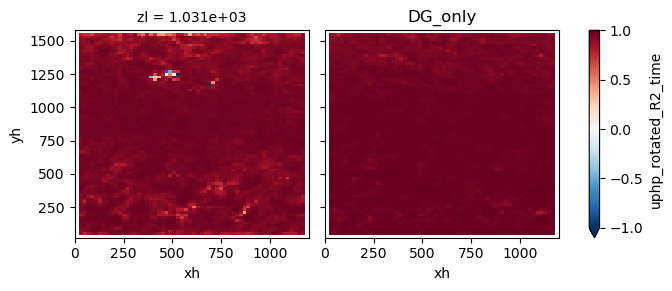

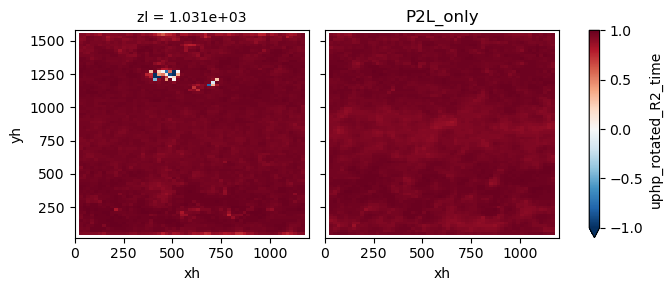

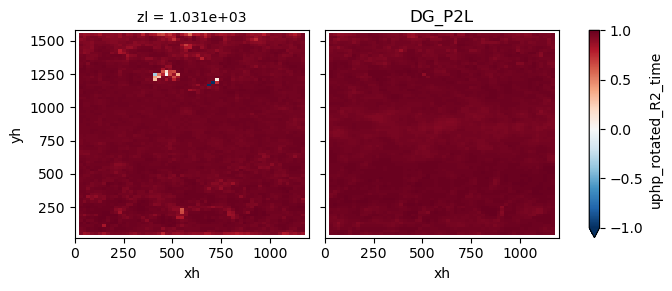

In [22]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

In [23]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].uphp_rotated_R2_time

<xarray.DataArray 'uphp_rotated_R2_time' (zl: 2, yh: 18, xh: 15)> Size: 4kB
dask.array<sub, shape=(2, 18, 15), dtype=float64, chunksize=(2, 17, 14), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 120B 40.0 120.0 200.0 ... 1e+03 1.08e+03 1.16e+03
  * yh       (yh) float64 144B 120.0 200.0 280.0 ... 1.32e+03 1.4e+03 1.48e+03
  * zl       (zl) float64 16B 1.031e+03 1.033e+03

Text(0.5, 1.0, 'DG_P2L')

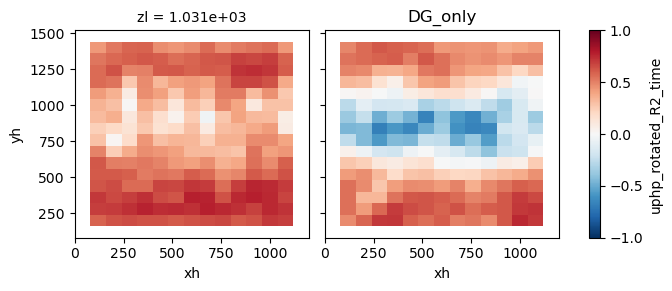

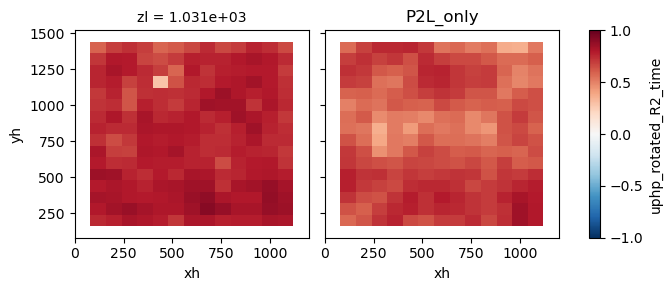

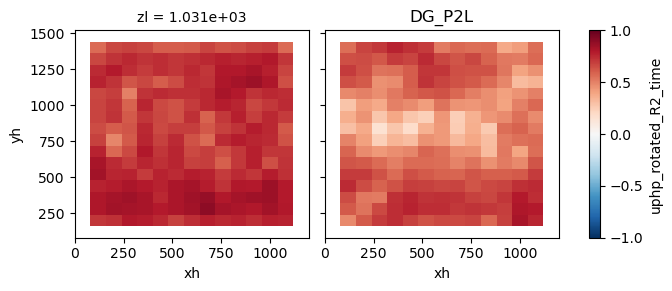

In [24]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

Text(0.5, 1.0, 'DG_P2L')

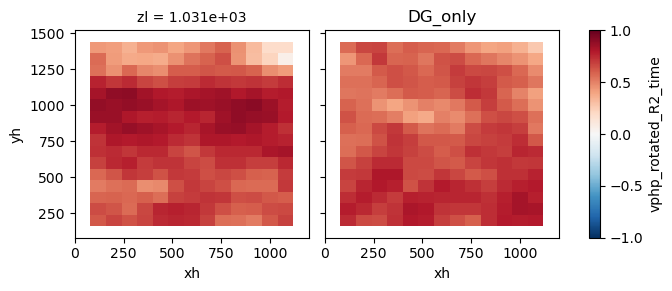

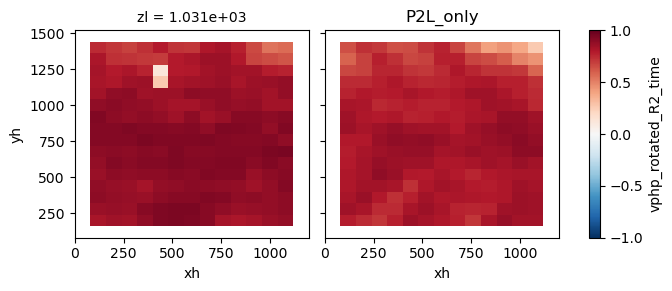

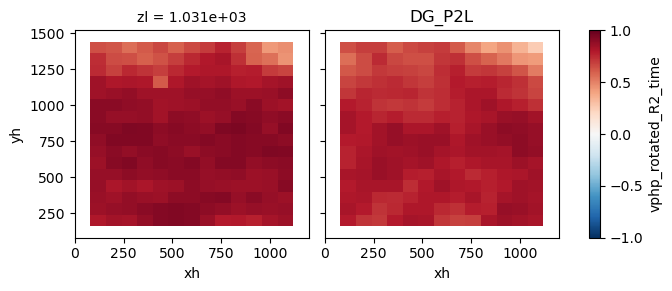

In [25]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].vphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_only')
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].vphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('P2L_only')
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].vphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('DG_P2L')

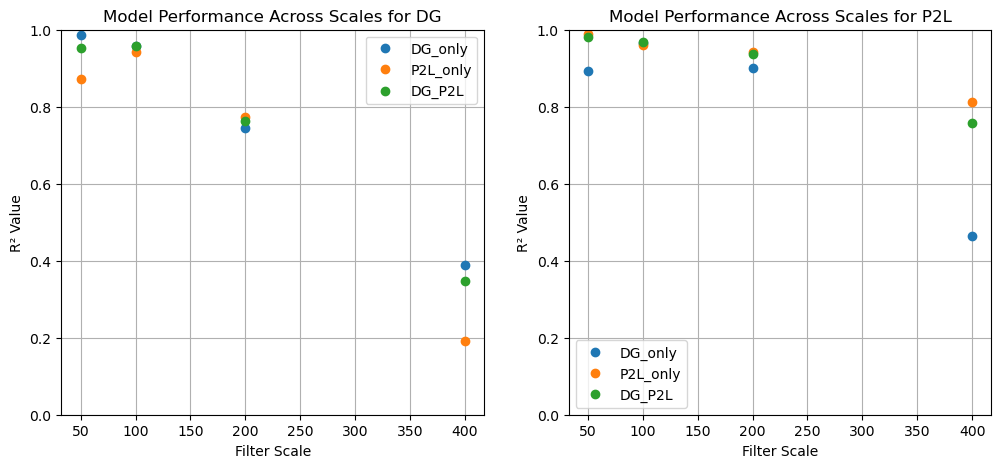

In [26]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(12, 5))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_all.values
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Model Performance Across Scales for " + data_key )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

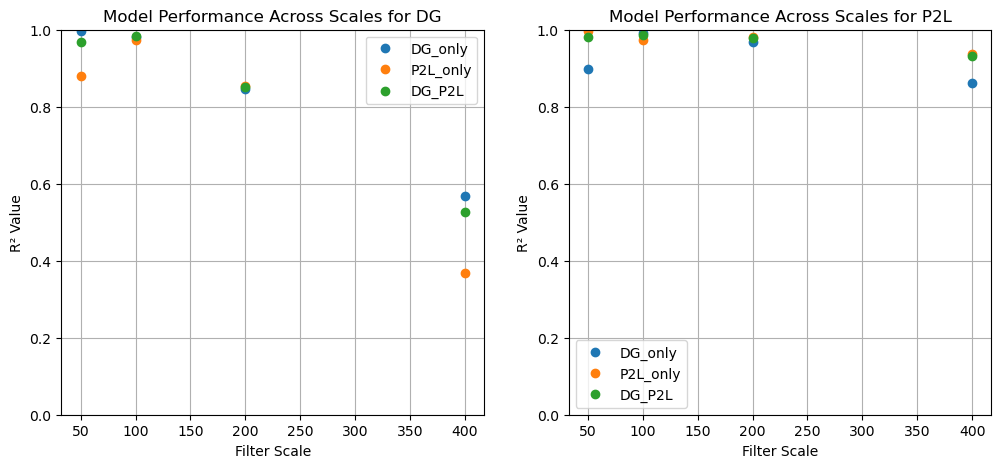

In [16]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(12, 5))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_all.values
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Model Performance Across Scales for " + data_key )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

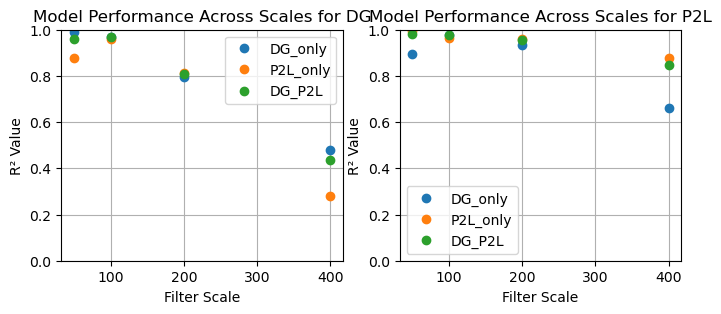

In [29]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 3))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = 0.5*(exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_all.values +
                            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Skill on " + data_key + " data" )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

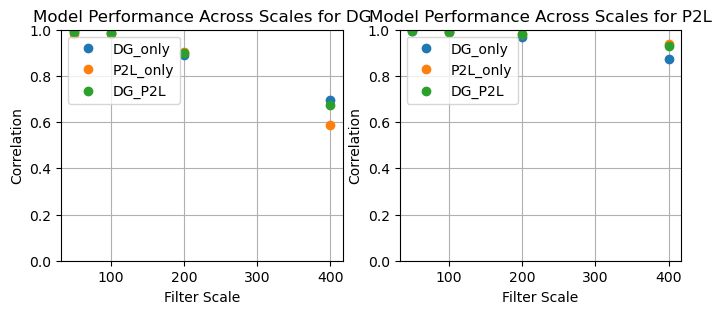

In [30]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 3))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = 0.5*(exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_corr_all.values +
                            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_corr_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("Correlation")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Model Performance Across Scales for " + data_key )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

In [32]:
for set_keys in exp_sets.keys():
    print(set_keys)

    #exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics
    exp_sets[set_keys]['eval_sys'].calc_PS(var='uphp_rotated', use_default_subregions=True)
    exp_sets[set_keys]['eval_sys'].calc_PS(var='vphp_rotated', use_default_subregions=True)

DG_only
P2L_only
DG_P2L


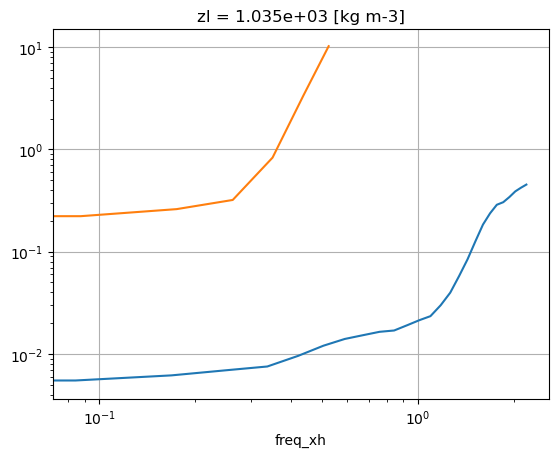

In [33]:
(exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_ps_anom_zonal.isel(zl=0) / exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].vphp_rotated_ps_zonal.isel(zl=0)).plot()
(exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].uphp_rotated_ps_anom_zonal.isel(zl=0) / exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].vphp_rotated_ps_zonal.isel(zl=0)).plot()
plt.xscale('log')
plt.yscale('log')
plt.grid('on')

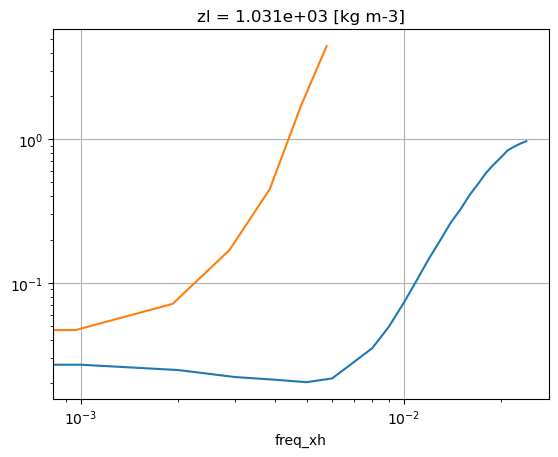

In [38]:
(exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_ps_anom_zonal.isel(zl=0) / 
 exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_ps_zonal.isel(zl=0)).plot()
(exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].vphp_rotated_ps_anom_zonal.isel(zl=0) / 
 exp_sets[set_keys]['eval_sys'].eval_datatree.ml_dataset['P2L']['400'].vphp_rotated_ps_zonal.isel(zl=0)).plot()
plt.xscale('log')
plt.yscale('log')
plt.grid('on')

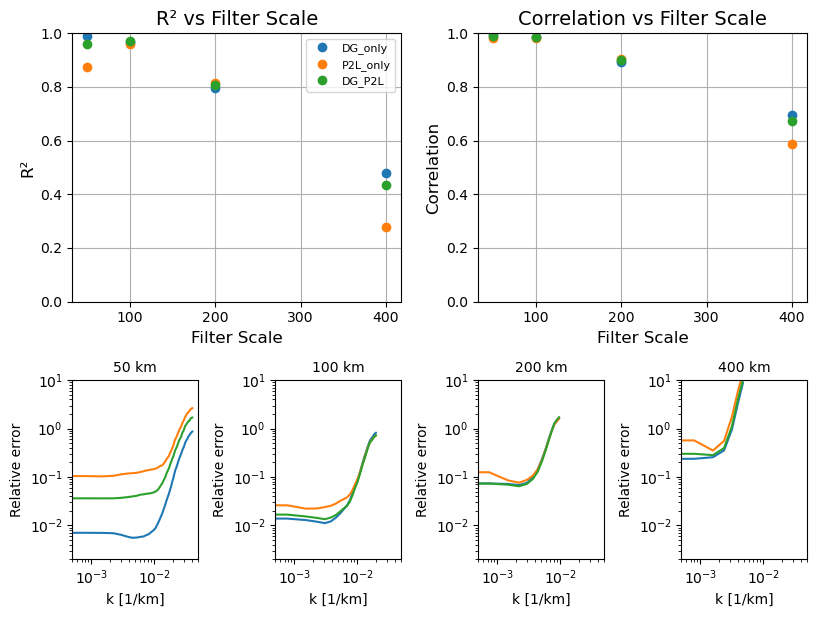

In [35]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define figure size for A4 sheet in inches (portrait layout)
fig = plt.figure(figsize=(8.27, 6.27))

# Create a grid layout with 3 rows and 4 columns
gs = gridspec.GridSpec(2, 4, height_ratios=[1.5, 1])  # Top row is taller

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

## First Row: R² vs Filter Scale (Left) & Correlation vs Filter Scale (Right)
ax1 = fig.add_subplot(gs[0, :2])  # First plot spans two columns
ax2 = fig.add_subplot(gs[0, 2:])  # Second plot spans the other two columns


exp_name = 'DG'

# Plot R² vs Filter Scale
for model_key in exp_sets.keys():
    flag = 0
    
    for scale in experiment_config['filter_scales']:
        R2_value = 0.5 * (
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values +
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax1.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax1.plot(int(scale), R2_value, 'o', color=color, markersize=6)

ax1.legend(fontsize=8)
ax1.set_xlabel("Filter Scale", fontsize=12)
ax1.set_ylabel("R²", fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid()
ax1.set_title("R² vs Filter Scale", fontsize=14)

# Plot Correlation vs Filter Scale
for model_key in exp_sets.keys():
    flag = 0

    for scale in experiment_config['filter_scales']:
        R2_value = 0.5 * (
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values +
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax2.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax2.plot(int(scale), R2_value, 'o', color=color, markersize=6)

#ax2.legend(fontsize=8)
ax2.set_xlabel("Filter Scale", fontsize=12)
ax2.set_ylabel("Correlation", fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid()
ax2.set_title("Correlation vs Filter Scale", fontsize=14)

## Second Row: uphp_rotated_ps_anom_zonal / uphp_rotated_ps_zonal (Smaller)
for i, scale in enumerate(experiment_config['filter_scales']):
    ax = fig.add_subplot(gs[1, i])
    for key in exp_sets.keys():
        ds = exp_sets[key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale]
        ax.plot(ds.freq_xh / 110, 
                ( 0.5*((ds.uphp_rotated_ps_anom_zonal / ds.uphp_rotated_ps_zonal) + (ds.vphp_rotated_ps_anom_zonal / ds.vphp_rotated_ps_zonal)) ).isel(zl=0).data, 
                color=color_map[key], label=key)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([2e-3, 10])
    ax.set_xlim([1/2000, 1/20])
    ax.set_title(f"{scale} km", fontsize=10)
    ax.set_xlabel("k [1/km]", fontsize=10)
    ax.set_ylabel("Relative error", fontsize=10)


# Add legend only once
#fig.legend(fontsize=8, loc="upper right")

plt.tight_layout()
#plt.savefig("impact_loss_style.pdf", format="pdf", dpi=300, bbox_inches="tight")  # High-res for printing
#plt.show()


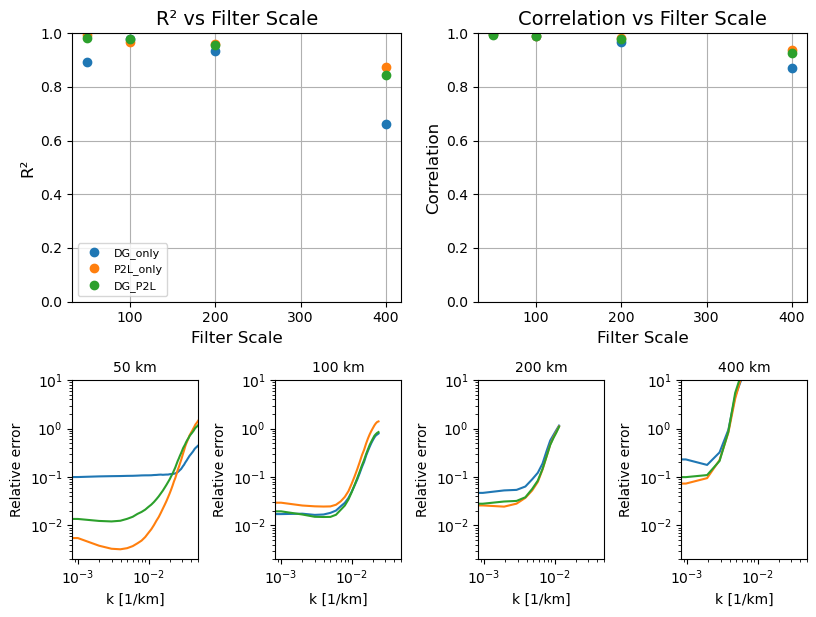

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define figure size for A4 sheet in inches (portrait layout)
fig = plt.figure(figsize=(8.27, 6.27))

# Create a grid layout with 3 rows and 4 columns
gs = gridspec.GridSpec(2, 4, height_ratios=[1.5, 1])  # Top row is taller

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

## First Row: R² vs Filter Scale (Left) & Correlation vs Filter Scale (Right)
ax1 = fig.add_subplot(gs[0, :2])  # First plot spans two columns
ax2 = fig.add_subplot(gs[0, 2:])  # Second plot spans the other two columns


exp_name = 'P2L'

# Plot R² vs Filter Scale
for model_key in exp_sets.keys():
    flag = 0
    
    for scale in experiment_config['filter_scales']:
        R2_value = 0.5 * (
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values +
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax1.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax1.plot(int(scale), R2_value, 'o', color=color, markersize=6)

ax1.legend(fontsize=8)
ax1.set_xlabel("Filter Scale", fontsize=12)
ax1.set_ylabel("R²", fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid()
ax1.set_title("R² vs Filter Scale", fontsize=14)

# Plot Correlation vs Filter Scale
for model_key in exp_sets.keys():
    flag = 0

    for scale in experiment_config['filter_scales']:
        R2_value = 0.5 * (
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values +
            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax2.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax2.plot(int(scale), R2_value, 'o', color=color, markersize=6)

#ax2.legend(fontsize=8)
ax2.set_xlabel("Filter Scale", fontsize=12)
ax2.set_ylabel("Correlation", fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid()
ax2.set_title("Correlation vs Filter Scale", fontsize=14)

## Second Row: uphp_rotated_ps_anom_zonal / uphp_rotated_ps_zonal (Smaller)
for i, scale in enumerate(experiment_config['filter_scales']):
    ax = fig.add_subplot(gs[1, i])
    for key in exp_sets.keys():
        ds = exp_sets[key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale]
        ax.plot(ds.freq_xh, 
                ( 0.5*((ds.uphp_rotated_ps_anom_zonal / ds.uphp_rotated_ps_zonal) + (ds.vphp_rotated_ps_anom_zonal / ds.vphp_rotated_ps_zonal)) ).isel(zl=0).data, 
                color=color_map[key], label=key)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([2e-3, 10])
    ax.set_xlim([1/1200, 1/20])
    ax.set_title(f"{scale} km", fontsize=10)
    ax.set_xlabel("k [1/km]", fontsize=10)
    ax.set_ylabel("Relative error", fontsize=10)


# Add legend only once
#fig.legend(fontsize=8, loc="upper right")

plt.tight_layout()
#plt.savefig("impact_loss_style.pdf", format="pdf", dpi=300, bbox_inches="tight")  # High-res for printing
#plt.show()


In [45]:
exp_sets.keys()

dict_keys(['DG_only', 'P2L_only', 'DG_P2L'])

In [46]:
exp_sets['DG_only']['fig_label'] = 'Trained on DG'
exp_sets['P2L_only']['fig_label'] = 'Trained on P2L'
exp_sets['DG_P2L']['fig_label'] = 'Trained on DG and P2L'

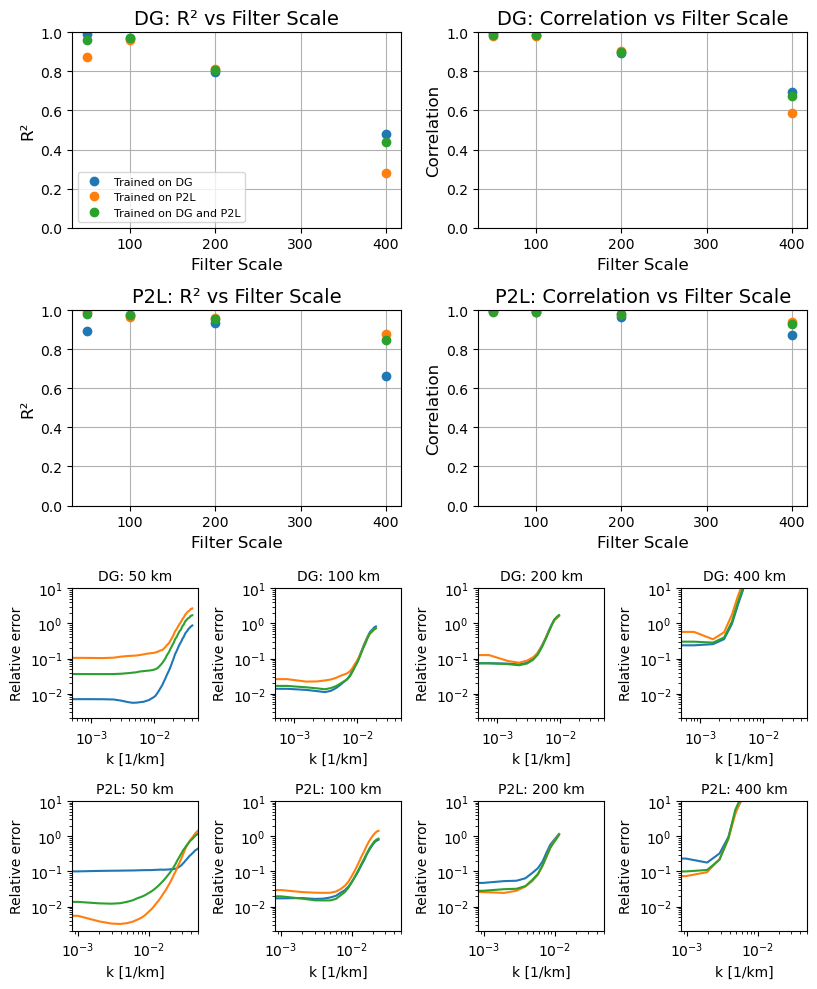

In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define figure size for A4 sheet in inches (portrait layout)
fig = plt.figure(figsize=(8.27, 10.0))  # Taller figure for more rows

# Create a grid layout with 4 rows and 4 columns
gs = gridspec.GridSpec(4, 4, height_ratios=[1.5, 1.5, 1, 1])  # Top rows are taller

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

def plot_r2_corr(ax_r2, ax_corr, exp_name, add_legend=False):
    """ Helper function to plot R² and correlation for a given experiment name. """
    handles = []
    labels = []

    for model_key in exp_sets.keys():
        flag = 0

        for scale in experiment_config['filter_scales']:
            R2_value = 0.5 * (
                exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values +
                exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
            )
            color = color_map[model_key]
            handle, = ax_r2.plot(int(scale), R2_value, 'o', color=color, markersize=6)
            if flag == 0:
                handles.append(handle)
                labels.append(exp_sets[model_key]['fig_label'])
                flag = 1

        flag = 0
        for scale in experiment_config['filter_scales']:
            Corr_value = 0.5 * (
                exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values +
                exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values
            )
            ax_corr.plot(int(scale), Corr_value, 'o', color=color, markersize=6)

    if add_legend:
        ax_r2.legend(handles, labels, fontsize=8, loc="lower left")  # Legend added only for first plot

    ax_r2.set_xlabel("Filter Scale", fontsize=12)
    ax_r2.set_ylabel("R²", fontsize=12)
    ax_r2.set_ylim([0, 1])
    ax_r2.grid()
    ax_r2.set_title(f"{exp_name}: R² vs Filter Scale", fontsize=14)
    
    ax_corr.set_xlabel("Filter Scale", fontsize=12)
    ax_corr.set_ylabel("Correlation", fontsize=12)
    ax_corr.set_ylim([0, 1])
    ax_corr.grid()
    ax_corr.set_title(f"{exp_name}: Correlation vs Filter Scale", fontsize=14)

# Row 1: DG (R² & Correlation)
ax1 = fig.add_subplot(gs[0, :2])  # R² (DG)
ax2 = fig.add_subplot(gs[0, 2:])  # Correlation (DG)
plot_r2_corr(ax1, ax2, "DG", add_legend=True)  # Legend added here

# Row 2: P2L (R² & Correlation)
ax3 = fig.add_subplot(gs[1, :2])  # R² (P2L)
ax4 = fig.add_subplot(gs[1, 2:])  # Correlation (P2L)
plot_r2_corr(ax3, ax4, "P2L")  # No legend here

def plot_spectral(ax_list, exp_name, x_min, x_max):
    """ Helper function to plot spectral analysis for a given experiment name. """
    for i, scale in enumerate(experiment_config['filter_scales']):
        ax = ax_list[i]
        for key in exp_sets.keys():
            ds = exp_sets[key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale]

            # Correct scaling factor usage
            scale_fac_x = 110 if exp_name == "DG" else 1

            ax.plot(ds.freq_xh / scale_fac_x, 
                    (0.5 * ((ds.uphp_rotated_ps_anom_zonal / ds.uphp_rotated_ps_zonal) + 
                            (ds.vphp_rotated_ps_anom_zonal / ds.vphp_rotated_ps_zonal))).isel(zl=0).data, 
                    color=color_map[key], label=key)
            

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([2e-3, 10])
        ax.set_xlim([x_min, x_max])
        ax.set_title(exp_name + ': ' + f"{scale} km", fontsize=10)
        ax.set_xlabel("k [1/km]", fontsize=10)
        ax.set_ylabel("Relative error", fontsize=10)

# Row 3: Spectral Analysis for DG
ax_list_dg = [fig.add_subplot(gs[2, i]) for i in range(4)]
plot_spectral(ax_list_dg, "DG", 1/2000, 1/20)

# Row 4: Spectral Analysis for P2L
ax_list_p2l = [fig.add_subplot(gs[3, i]) for i in range(4)]
plot_spectral(ax_list_p2l, "P2L", 1/1200, 1/20)

plt.tight_layout()
#plt.show()

plt.savefig("impact_training_exp.pdf", format="pdf", dpi=300, bbox_inches="tight")  # High-res for printing
